## <span style='color:black'> Memorability Score prediction of videos with <span style='background:yellow'>HMP, C3D, and Aesthetics features </span>  </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -U --user -q --no-warn-script-location tensorflow
!pip install -U --user -q --no-warn-script-location pandas
!pip install -U --user -q --no-warn-script-location numpy
!pip install -U --user -q --no-warn-script-location sklearn
!pip install -U --user -q --no-warn-script-location matplotlib
!pip install -U --user -q --no-warn-script-location progressbar

ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.


## <span style='color:green'> Mounting the Google Drive folder with all the data for experiment </span>

In [2]:
# Code to create a connection between Google Colab and folder with data at Google Drive
#from google.colab import drive
#import os
#drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive/CA684_Assignment/')
#os.chdir('/content/drive/My Drive/CA684/')

## <span style='color:green' size=12> Import required libraries </span>

<ul>
    <li><a href="https://pypi.org/project/pandas/">Pandas </a> - Pandas is an open-source, BSD-licensed Python library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
    <li><a href="https://keras.io/api/">Keras</a> - Keras is a powerful easy-to-use Python library for developing and evaluating deep learning models.
    <li><a href='https://numpy.org/doc/stable/user/absolute_beginners.html'> Numpy </a> - NumPy, which stands for Numerical Python, is a library consisting of multidimensional array objects and a collection of routines for processing those arrays.
    <li><a href='https://scikit-learn.org/stable/'> Sklean (Scikit-Learn) </a> sklearn library contains a lot of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction.
    <li><a href='https://matplotlib.org/'> Matplotlib </a> - Matplotlib is a cross-platform, data visualization and graphical plotting library for Python and its numerical extension NumPy.
    <li><a href='https://www.tensorflow.org/'> Tensorflow </a> - TensorFlow is the second machine learning framework used for designing, building, and training deep learning models. 
        

In [3]:
import  pandas as pd
from keras import Sequential
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import tensorflow
import os


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import metrics

In [5]:
# for reproducibility of pseudo-random numbers
from numpy.random import seed
seed(1)

# Import of Progressbar library to show the status of any long process in data processing methods
from progressbar import ProgressBar
pbar = ProgressBar()

In [6]:
import os
current_directory = os.getcwd()
print(current_directory)

C:\Users\Dell\Documents\CA684


In [7]:
# Ground Truth common file for all models with different feature test experiments

# Read Ground Truth file in Dev-set folder
ground_truth_path = os.path.join(current_directory,'Dev-set', 'Ground-truth')
ground_truth_labels = pd.read_csv(os.path.join(ground_truth_path, 'ground-truth.csv'))


# Read Ground Truth file in Test-set folder
ground_truth_test_path = os.path.join(current_directory,'Test-set', 'Ground-truth_test')
ground_truth_test_labels = pd.read_csv(os.path.join(ground_truth_test_path, 'ground_truth_template.csv'))


### <span style='color:orange' size=12> Predict Spearmann's Correlation Cofficient Score Common Function </span>

In [8]:
# Function to Predict Short term and Long term Spearmann's correlation coefficient scores
def Predict_Spearman_Score(Y_predicted,Y_actual):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_predicted = np.squeeze(Y_predicted)
    Y_actual = np.squeeze(Y_actual)

    if Y_predicted.shape != Y_actual.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_predicted.shape) == 1:
            Res = pd.DataFrame({'Y_actual':Y_actual,'Y_predicted':Y_predicted})
            score_mat = Res[['Y_actual','Y_predicted']].corr(method='spearman',min_periods=1)
            print('Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
            
        else:
            for k in range(Y_predicted.shape[1]):
                if(k == 0):
                    print('Short term memorability')
                    Predict_Spearman_Score(Y_predicted[:,k],Y_actual[:,k])
                else:
                    print('\nLong term memorability')
                    Predict_Spearman_Score(Y_predicted[:,k],Y_actual[:,k])

# <span style='color:green'>Memorability Score Prediction with HMP features <span>

### <span style='color:orange'> Function to read HMP (Histogram of Motion Patterns) features </span>

In [9]:
def read_HMP_data(fname):
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}

    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

#### <span style='color:blue'> Code to read HMP features into hmp_features DataFrame </span>

In [10]:
hmp_feature_path = current_directory + '/Dev-set/'
# Load video related features
videos = ground_truth_labels.video.values

hmp_features = pd.DataFrame({'video': videos,
                   'HMP': [read_HMP_data(hmp_feature_path + 'HMP'+'/'+ os.path.splitext(videos[video])[0]+'.txt') for video in pbar(range(len(videos)))]
                       })


100% |########################################################################|


In [11]:
# Check DataFrame shape
hmp_features.shape


(6000, 2)

#### <span style='color:blue'> Split HMP features into training and train dataset </span>

*The targets here are the short-term and long-term scores*

In [12]:
# Join the sequence of arrays in along a axis

X = np.stack(hmp_features['HMP'].values)

# Read the Ground Truth label values stored in Dev dataset
Y = ground_truth_labels[['short-term_memorability','long-term_memorability']].values

# Break the input with 80% of data in (X_train, Y_train) for training of data and rest 20% data of (X_val, Y_val) to validate the model
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

X_train.shape

(4800, 6075)

In [13]:
print(type(X_train[0]))

<class 'numpy.ndarray'>


### <span style='color:red'> <span style='background:yellow'> Linear Regression </span> on HMP Features </span>

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable.

A linear regression line has an equation of the form Y = a + bX, where X is the explanatory variable and Y is the dependent variable. The slope of the line is b, and a is the intercept (the value of y when x = 0).

In [14]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_regression.fit(X_train, Y_train)

Y_pred = linear_regression.predict(X_val)
Predict_Spearman_Score(Y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.036

Long term memorability
Spearman's correlation coefficient is: -0.004


### <span style='color:green'> Residual Plots for Linear Regression </span>

The plot of residuals versus predicted values is useful for checking the assumption of linearity and homoscedasticity. If the model does NOT meet the linear model assumption, we would see our residuals take on a defined shape or a distinctive pattern. 

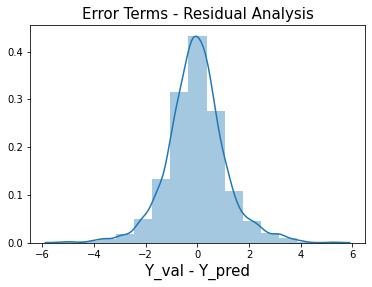

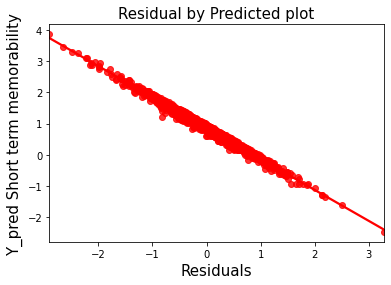

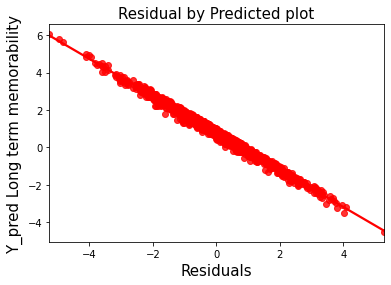

In [15]:
# Creating residuals from the Y_val data and predicted Y_pred
import seaborn as sns


res = Y_val - Y_pred

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms - Residual Analysis', fontsize = 15)
plt.xlabel('Y_val - Y_pred', fontsize = 15)
plt.show()

res2 = (Y_val[:,0] - Y_pred[:,0])

fig = plt.figure()
sns.regplot(x = res2, y = Y_pred[:,0], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Short term memorability',fontsize= 15)
plt.show()

res3 = (Y_val[:,1] - Y_pred[:,1])

fig = plt.figure()
sns.regplot(x = res3, y = Y_pred[:,1], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Long term memorability',fontsize= 15)
plt.show()

### <span style='color:red'><span style='background:yellow'>K-Neighbors Regression</span> on HMP Features </span>

K-nearest neighbors (KNN) algorithm is a type of supervised ML algorithm which can be used for both classification as well as regression predictive problems. 

1. KNN is a lazy learning algorithm because it does not have a specialized training phase and uses all the data for training while classification.
2. Non-parametric learning algorithm − KNN is also a non-parametric learning algorithm because it doesn’t assume anything about the underlying data.

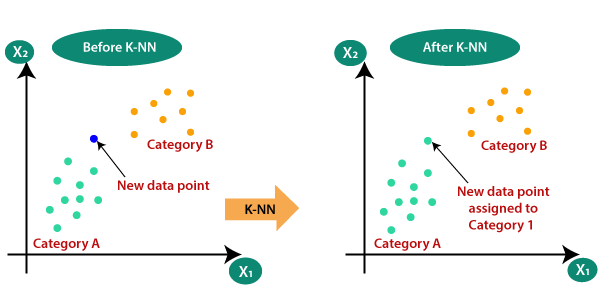

In [16]:
from sklearn.neighbors import KNeighborsRegressor
knnRegressor = KNeighborsRegressor(n_neighbors = 77)
knnRegressor.fit(X_train, Y_train)
Y_pred = knnRegressor.predict(X_val)
Predict_Spearman_Score(Y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.237

Long term memorability
Spearman's correlation coefficient is: 0.075


### <span style='color:red'> <span style='background:yellow'>DecisionTree Regression</span> on HMP Feature </span>

1. Decision tree algorithm falls under the category of supervised learning. They can be used to solve both regression and classification problems.
2. Decision tree uses the tree representation to solve the problem in which each leaf node corresponds to a class label and attributes are represented on the internal node of the tree.
3. Any boolean function can be represented on discrete attributes using the decision tree.



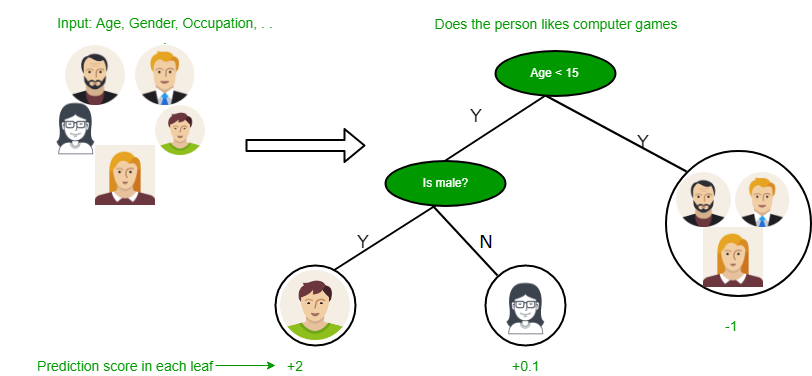

In [17]:
from sklearn.tree import DecisionTreeRegressor
dtRegressor = DecisionTreeRegressor()
dtRegressor.fit(X_train, Y_train)
Y_pred = dtRegressor.predict(X_val)
Predict_Spearman_Score(Y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.077

Long term memorability
Spearman's correlation coefficient is: 0.033


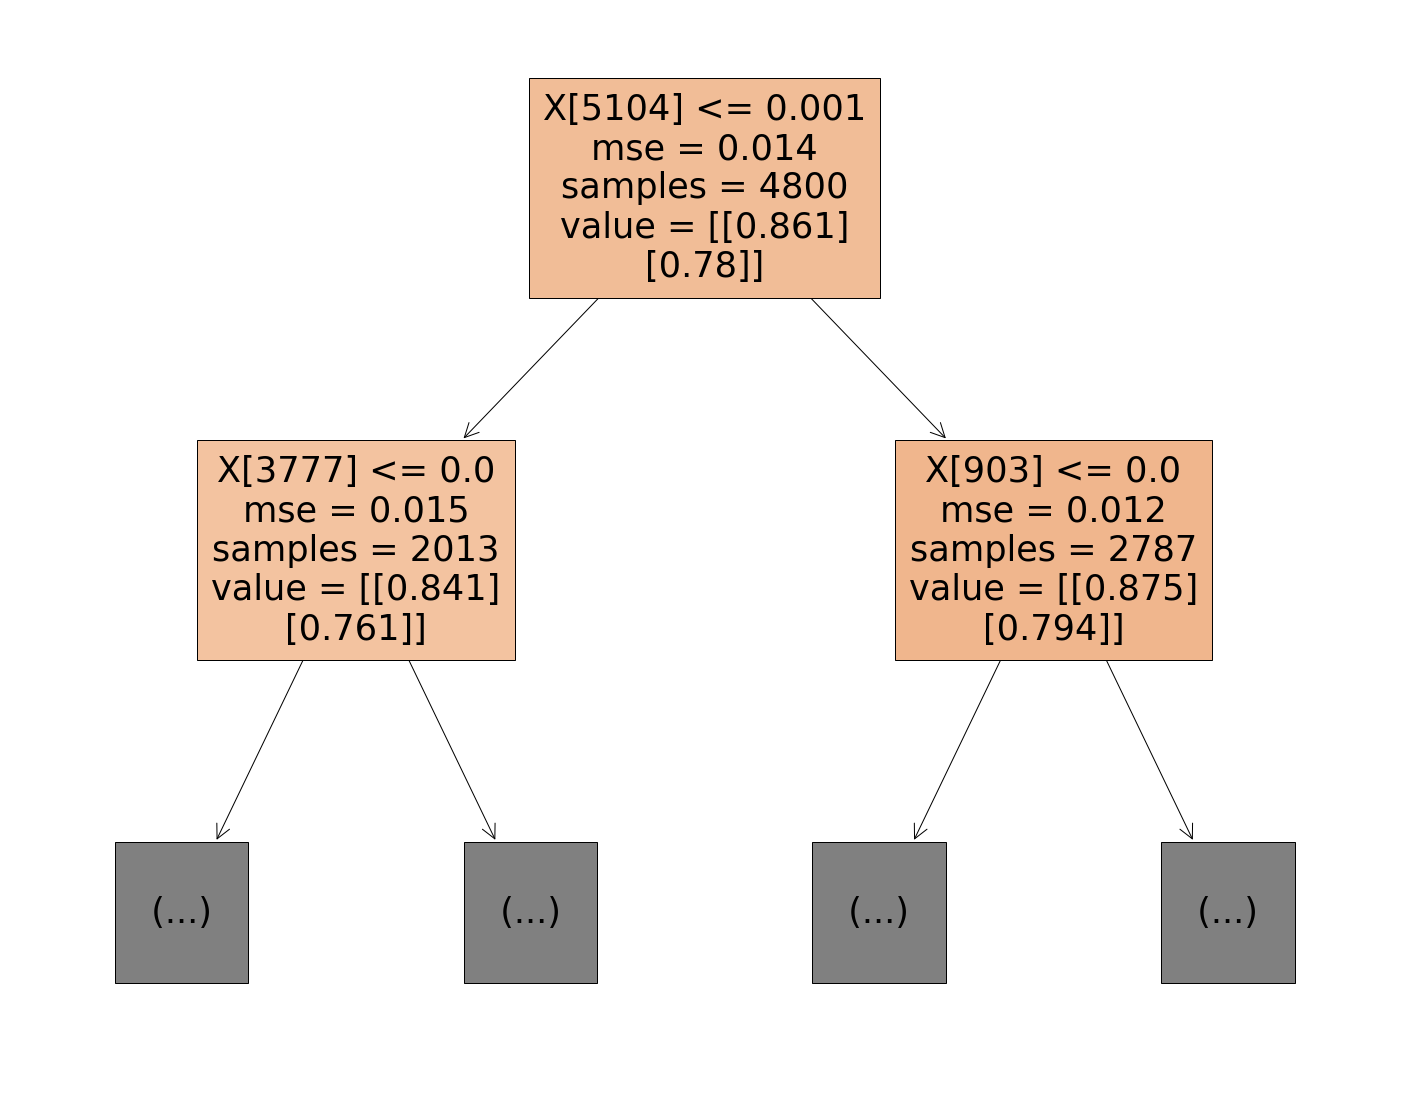

In [18]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtRegressor, X_val.any(), filled=True)

### <span style='color:red'> <span style='background:yellow'>Random Forest Regression </span> on HMP Feature
    
Random Forest that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. Random forest takes the prediction from each tree and based on the majority votes of predictions instead of relying on one decision tree, and then it predicts the final output.

The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting

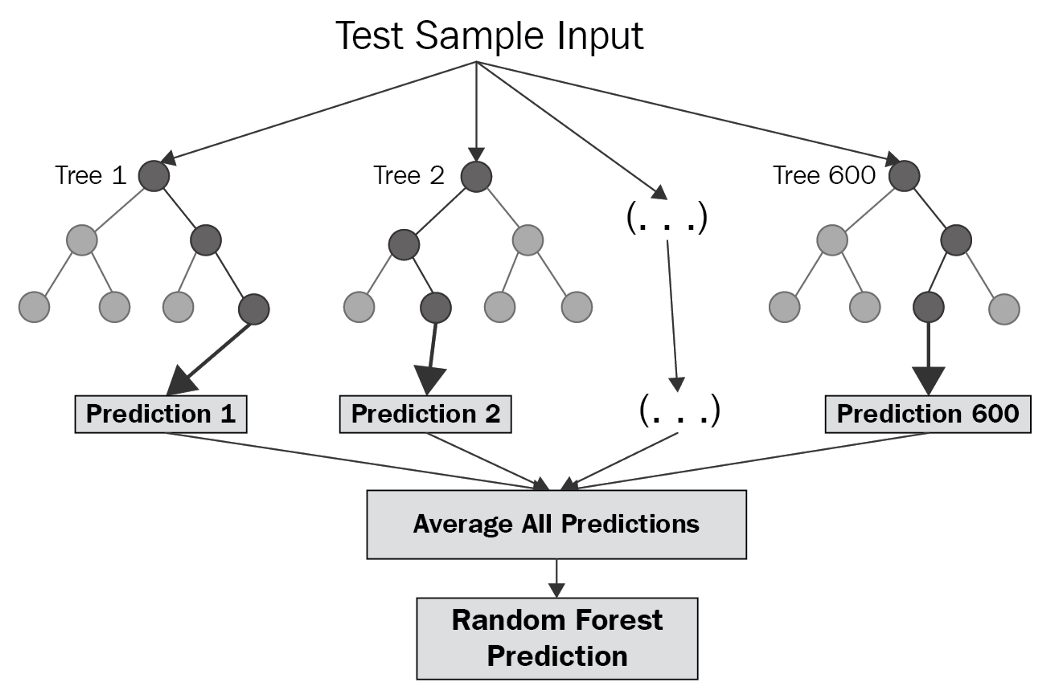

In [19]:
from sklearn.ensemble import RandomForestRegressor
rfRegressor = RandomForestRegressor(n_estimators=100, max_depth=16, min_samples_split = 5, random_state=42)
rfRegressor.fit(X_train,Y_train)
Y_pred = rfRegressor.predict(X_val)
Predict_Spearman_Score(Y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.275

Long term memorability
Spearman's correlation coefficient is: 0.113


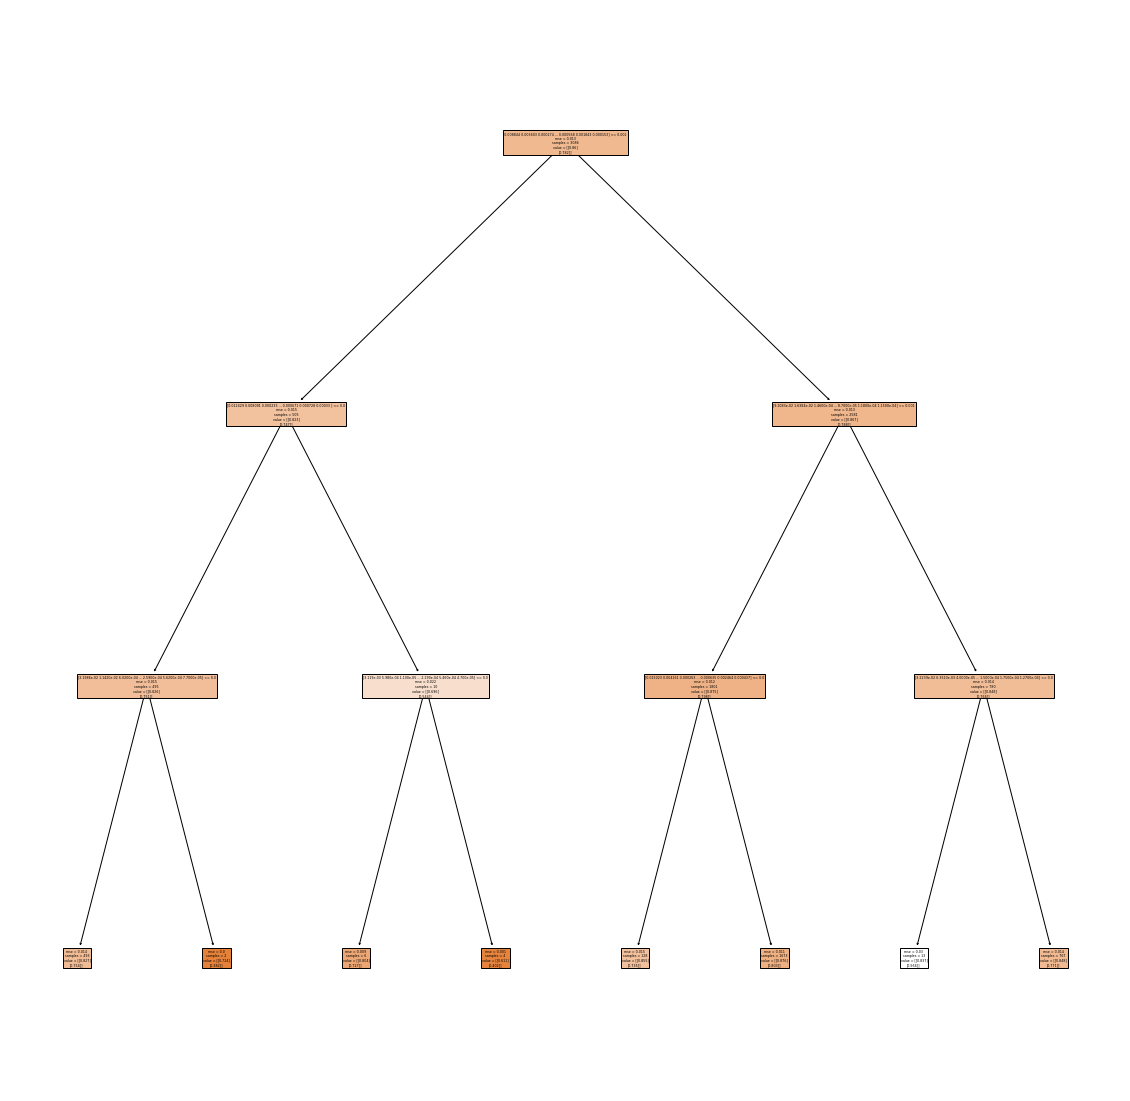

In [20]:
## Note: Below diagram an example of Random Forest tree with Depth 3 - to showcase how Regression Tree work with inputs

rfRegressor_plot = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split = 5, random_state=42)
rfRegressor_plot.fit(X_train,Y_train)
Y_pred_plot = rfRegressor_plot.predict(X_val)

from sklearn import tree
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})


plt.figure(figsize=(20,20)) 
_ = tree.plot_tree(rfRegressor_plot.estimators_[5], feature_names=X, filled=True)

### <span style='color:red'> <span style='background:yellow'>Neural Network </span> on HMP Feature
    
Neural networks are a set of algorithms, modeled loosely after the human brain, that are designed to recognize patterns. They interpret sensory data through a kind of machine perception, labeling or clustering raw input. The patterns they recognize are numerical, contained in vectors, into which all real-world data, be it images, sound, text or time series, must be translated.

### <span style='color:blue'>Build the Model </span>

A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 

The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

In [21]:
# Sequential Model - The Sequential model is a linear stack of layers.

hmp_model = Sequential()

# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# Add layers via the .add() method
hmp_model.add(layers.Dense(500,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))

# add dropout - Helps prevent overfitting
hmp_model.add(layers.Dropout(0.2))
hmp_model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
hmp_model.add(layers.Dropout(0.2))
hmp_model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
hmp_model.add(layers.Dropout(0.2))
hmp_model.add(layers.Dense(2,activation='sigmoid'))
hmp_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               3038000   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1

### <span style='color:blue'> Compile the Model </span>

Before training a model, compile the model to configure the learning process. 

It receives three arguments:

1.   An optimizer
2.   A loss function
3.   A list of metrics

In [22]:
hmp_model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])

### <span style='color:blue'> Train the model </span>

Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the *fit* function.

In [23]:
# Training the model   
history = hmp_model.fit(x=X_train, y=Y_train, batch_size=50, epochs=50, shuffle=True, verbose=False, validation_split=0.2) # validation_data=(X_val, Y_val)   

### <span style='color:green'> Visualisation of results </span>
- Visualising the loss and training results
- Visualising the short-term and long term scatter plot

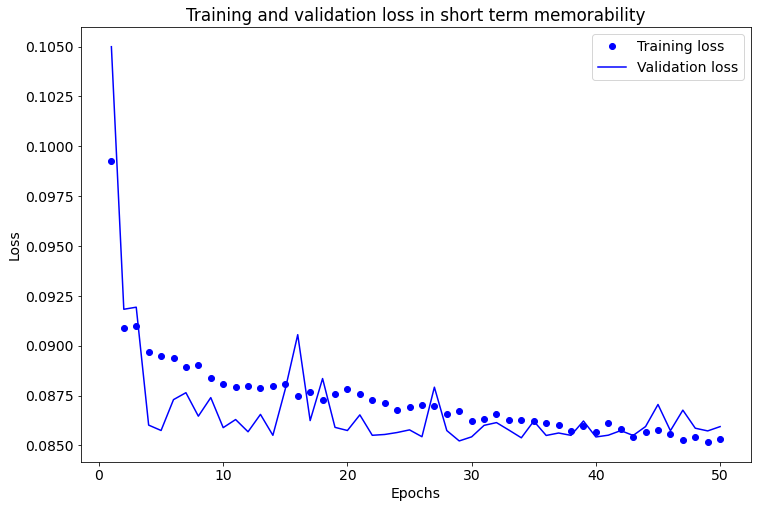

In [24]:
# Visualising the training loss vs validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1,len(training_loss)+1)

plt.figure()

plt.plot(epochs,training_loss,'bo',label='Training loss')
plt.plot(epochs,validation_loss,'b',label='Validation loss')
plt.title('Training and validation loss in short term memorability')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <span style='color:blue'> Read HMP test data from Test-set folder </span>

In [25]:
# Load testing data for HMP from the Test-set folder
HMP_FILENAMES_TEST = os.path.join(current_directory, 'Test-set')

videos = ground_truth_test_labels.video.values

pbar = ProgressBar()

test_hmp_features = pd.DataFrame({'video': videos,
                   'HMP': [read_HMP_data(os.path.join(HMP_FILENAMES_TEST, 'HMP_test', "".join(['video',str(video)])) + '.txt') for video in pbar (videos)]
                       })
# Join the sequence of arrays in along a axis
X_test_hmp = np.stack(test_hmp_features['HMP'].values)


100% |########################################################################|


### <span style='color:green'> Training and Validation prediction graph </span>

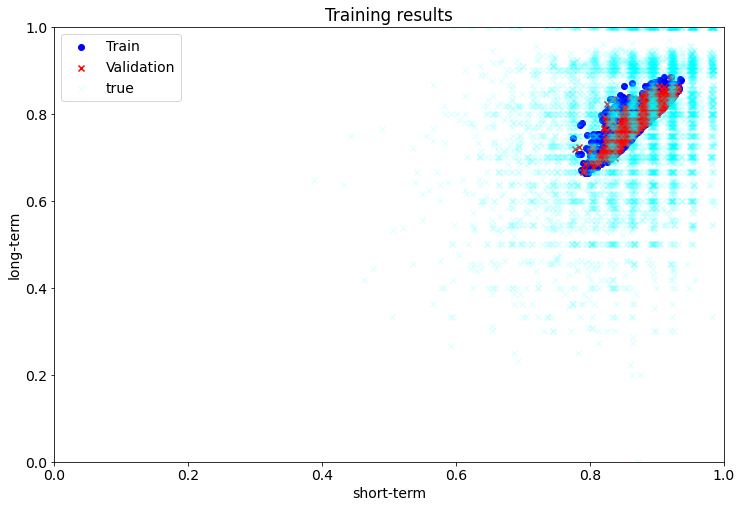

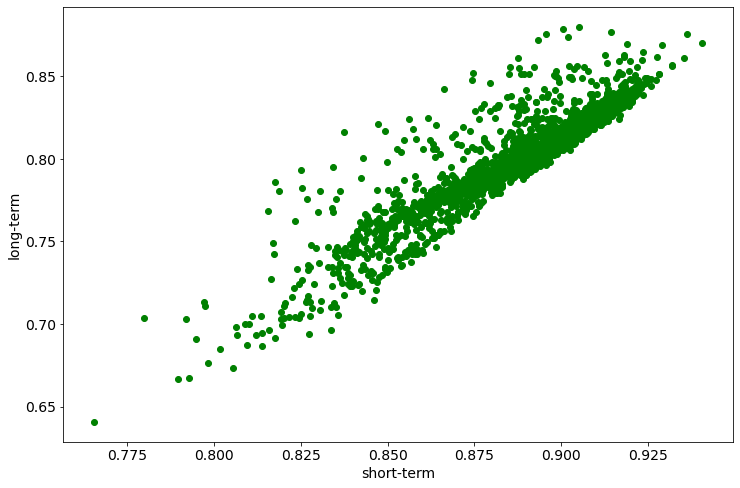

In [26]:

Y_predicted_train = history.model.predict(X_train)
Y_predicted_validation = history.model.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='b',label='Train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='red',label='Validation')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='cyan',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.title('Training results')
plt.show()
    
# plot testing results graph
Y_pred = history.model.predict(X_test_hmp[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='g', label='test')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()


## <span style='color:red'> Spearman Memorability Score with HMP feature </span>

 Spearman rank correlation is a non-parametric test that is used to measure the degree of association between two variables.  The Spearman rank correlation test does not carry any assumptions about the distribution of the data and is the appropriate correlation analysis when the variables are measured on a scale that is at least ordinal.

The following formula is used to calculate the Spearman rank correlation:

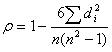

ρ= Spearman rank correlation
di= the difference between the ranks of corresponding variables
n= number of observations

In [27]:
# Memorability Score

Predict_Spearman_Score(Y_predicted_validation,Y_val)


Short term memorability
Spearman's correlation coefficient is: 0.323

Long term memorability
Spearman's correlation coefficient is: 0.135


### <span style='color:blue'> Neural Net Validation loss & Validation Accuracy Scores </span>

In [28]:
score = hmp_model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.08804211020469666
Validation accuracy: 0.7091666460037231


# <span style='color:green'>Memorability Score Prediction with C3D features <span>

### <span style='color:orange'> Functions to read C3D features from C3D folder in Dev-set folder </span>

In [29]:
# Function to read each line of C3D file for its features"""              
def read_C3D_data(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

In [30]:
# Load the C3D feature values in a Panda's dataframe
c3d_feature_path = current_directory + '/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
videos = ground_truth_labels.video.values
pbar = ProgressBar()

c3d_features = pd.DataFrame({'video': videos,
                   'C3D': [read_C3D_data(c3d_feature_path +'C3D'+'/'+ os.path.splitext(videos[video])[0]+'.txt') for video in pbar(range(len(videos)))],
                       })


100% |########################################################################|


In [31]:
c3d_features.head(2)

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."


In [32]:
# Get the C3D features values in X variable
X = np.stack(c3d_features['C3D'].values)

# Get the Short term and Long Term memorabiity score for video in training set
Y = ground_truth_labels[['short-term_memorability','long-term_memorability']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
print('X_train ', X_train.shape)
print('X_val  ', X_val.shape)
print('Y_train ', Y_train.shape)
print('Y_val  ', Y_val.shape)

X_train  (4800, 101)
X_val   (1200, 101)
Y_train  (4800, 2)
Y_val   (1200, 2)


### <span style='color:red'> <span style='background:yellow'> Linear Regression </span> on C3D features </span>

In [34]:
#linear regression
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, Y_train)
y_pred = linearRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.277

Long term memorability
Spearman's correlation coefficient is: 0.103


In [35]:
print(len(Y_val))

1200


#### <span style='color:green'> Residual by Predicted Plot </span>

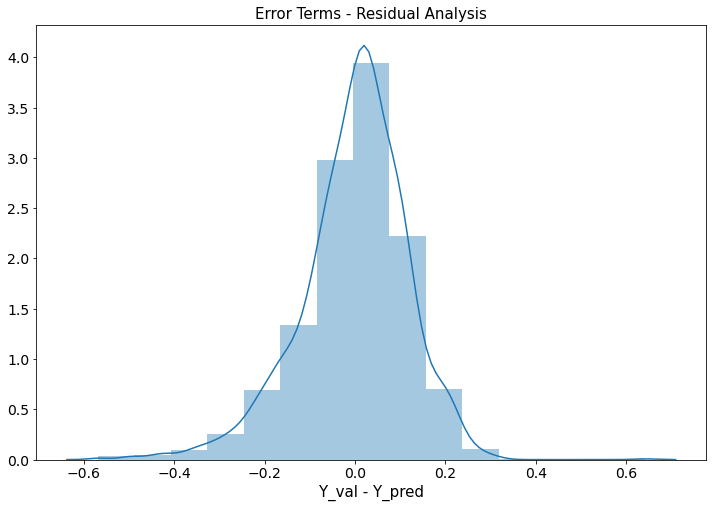

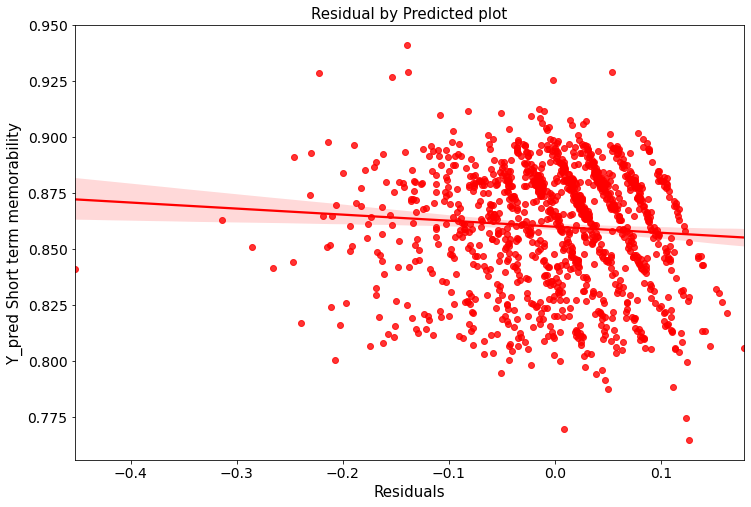

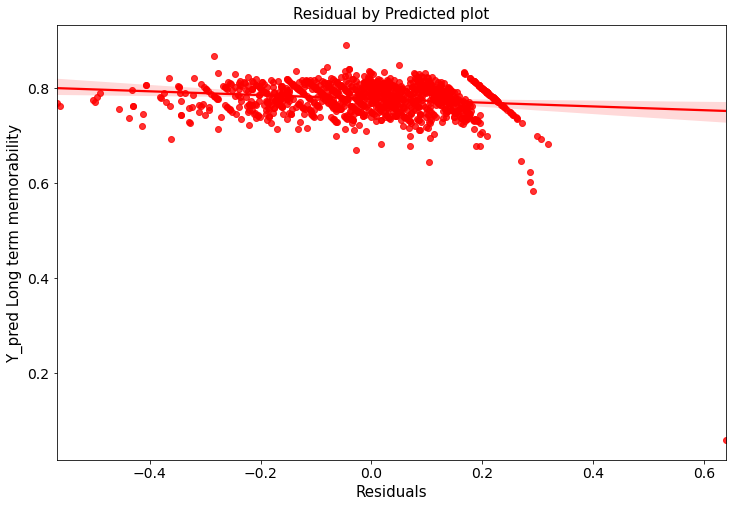

In [36]:
# Creating residuals from the Y_val data and predicted Y_pred
import seaborn as sns


res = Y_val - y_pred

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms - Residual Analysis', fontsize = 15)
plt.xlabel('Y_val - Y_pred', fontsize = 15)
plt.show()

res2 = (Y_val[:,0] - y_pred[:,0])

fig = plt.figure()
sns.regplot(x = res2, y = y_pred[:,0], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Short term memorability',fontsize= 15)
plt.show()

res3 = (Y_val[:,1] - y_pred[:,1])

fig = plt.figure()
sns.regplot(x = res3, y = y_pred[:,1], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Long term memorability',fontsize= 15)
plt.show()

### <span style='color:red'> <span style='background:yellow'> KNN Regression </span> on C3D features </span>

In [37]:
knnRegressor = KNeighborsRegressor(n_neighbors = 77)
knnRegressor.fit(X_train, Y_train)
y_pred = knnRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.251

Long term memorability
Spearman's correlation coefficient is: 0.097


### <span style='color:red'> <span style='background:yellow'> Decision Tree Regression </span> on C3D features </span>

In [38]:
dtRegressor = DecisionTreeRegressor()
dtRegressor.fit(X_train, Y_train)
y_pred = dtRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.062

Long term memorability
Spearman's correlation coefficient is: -0.007


### <span style='color:red'> <span style='background:yellow'> Random Forest Regression </span> on C3D features </span>

In [39]:
rfRegressor = RandomForestRegressor(n_estimators=100, max_depth=16, min_samples_split = 5, random_state=1)
rfRegressor.fit(X_train,Y_train)
y_pred = rfRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.302

Long term memorability
Spearman's correlation coefficient is: 0.109


### <span style='color:red'> <span style='background:yellow'>Neural Network </span> on C3D Feature </span>

### <span style='color:green'> Build the Sequential Neural Network Model </span>

In [40]:
# Sequential Model - The Sequential model is a linear stack of layers.

c3dModel = Sequential()

# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# Add layers via the .add() method
c3dModel.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))

# add dropout - Helps prevent overfitting
c3dModel.add(layers.Dropout(0.2))
c3dModel.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
c3dModel.add(layers.Dropout(0.2))
c3dModel.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
c3dModel.add(layers.Dropout(0.2))
c3dModel.add(layers.Dense(2,activation='sigmoid'))
c3dModel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               20400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

### <span style='color:blue'> Compile the Neural Network Model </span>

In [41]:
c3dModel.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])

### <span style='color:blue'> Train the Model </span>

In [42]:
# Training the model   
history = c3dModel.fit(x=X_train, y=Y_train, batch_size=50, epochs=50, shuffle=True, verbose=False, validation_split=0.2) # validation_data=(X_val, Y_val) 

#### <span style='color:green'> Read the test C3D features from Test-Dev folder </span>

Load the test data for C3D features in X_test_c3d variable

In [43]:
# Load the testing data for C3D from the Test-set folder

C3D_FILENAMES_TEST = current_directory + '/Test-set/'
videos = ground_truth_test_labels.video.values

pbar = ProgressBar()

c3d_test = pd.DataFrame({'video': videos,
                   'C3D': [read_C3D_data(os.path.join(HMP_FILENAMES_TEST, 'C3D_test', "".join(['video',str(video)])) + '.txt') for video in pbar(videos)],
                       })

100% |########################################################################|


In [44]:
# Load C3D test videos features values in the variable X_test_c3d

X_test_c3d = np.stack(c3d_test['C3D'].values)

### <span style='color:green'> Visualisaton throught plots </span>
1. Visualising the loss and training results
2. Visualising the short-term and long term scatter plot

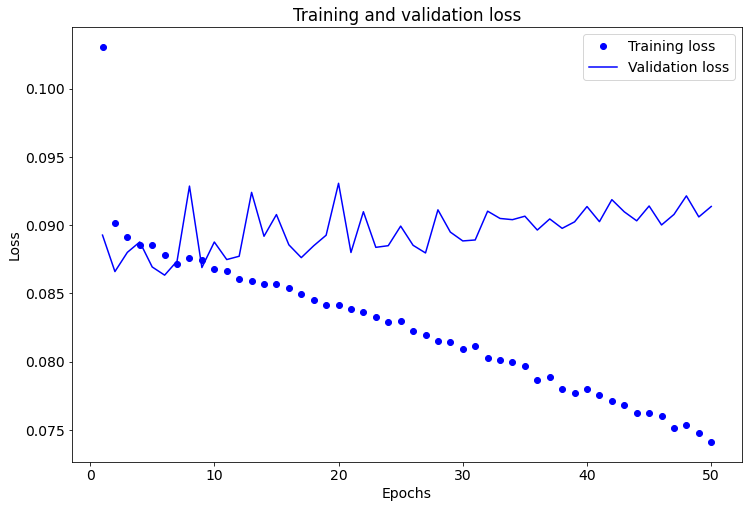

In [45]:
# Visualising the training loss vs validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


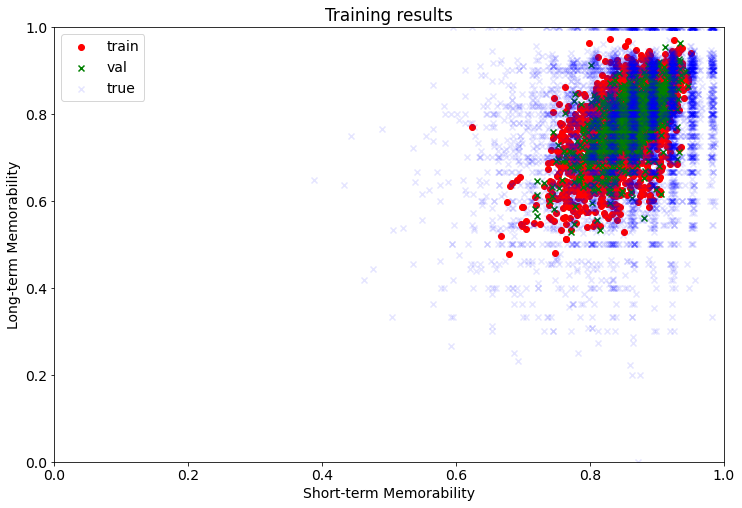

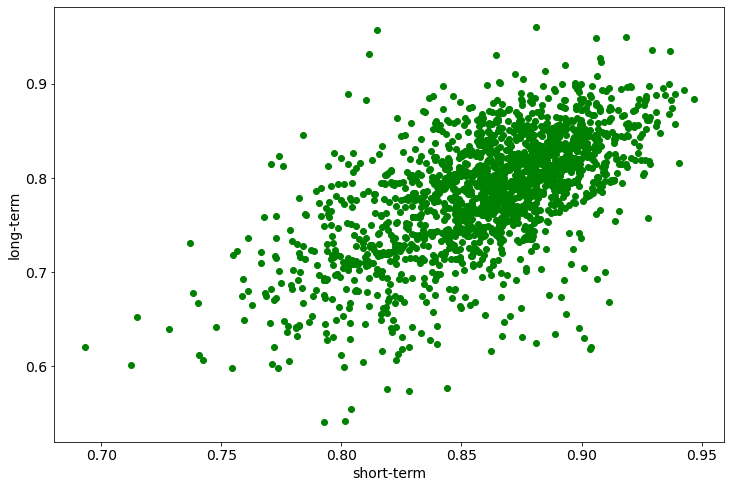

In [46]:
# Plot between Short term and long term memorability

Y_predicted_train = c3dModel.predict(X_train)
Y_predicted_validation = c3dModel.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='r',label='train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='g',label='val')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Short-term Memorability')
plt.ylabel('Long-term Memorability')
plt.title('Training results')
plt.show()

# plot testing results
Y_pred = c3dModel.predict(X_test_c3d[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='g')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()


In [47]:
# Predict the Short term and Long term memorability score using model for C3D test data set

Y_prediction = c3dModel.predict(X_val)

## <span style='color:red'> Spearman Memorability Score with C3D feature </span>

In [48]:
# Predict Short term and Long term Spearmann's correlation coefficient scores
Predict_Spearman_Score(Y_prediction,Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.230

Long term memorability
Spearman's correlation coefficient is: 0.081


In [49]:
# Predict loss and accuracy of Sequential mode
score = c3dModel.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.0919685959815979
Validation accuracy: 0.6941666603088379


# <span style='color:blue'> Predictions with joint HMP and C3D features </span>

##### <span style='color:red'> Note: </span> <span style='color:blue'>C3D and HMP features were already stored in dataframe in earlier steps, so they are used instead of calculating them again </span>

In [50]:
print(c3d_features.shape)
print(hmp_features.shape)

(6000, 2)
(6000, 2)


#### <span style='color:blue'> C3D and HMP features are merged </span>

In [51]:
#hmp_c3d_features = pd.merge(c3d_features, hmp_features, on='video')

c3d_features_new = c3d_features.filter(['C3D']).to_numpy()
hmp_features_new = hmp_features.filter(['HMP']).to_numpy()

counter = 0

cmd_hmp_features = np.array([])

combinedListWithC3D_HMP = []

for counter in range(6000):
    cmd_hmp_features = np.concatenate((c3d_features_new[counter][0], hmp_features_new[counter][0]))
    combinedListWithC3D_HMP.append(cmd_hmp_features)

print(len(combinedListWithC3D_HMP))


6000


In [52]:
c3d_hmp_dataframe = pd.DataFrame(data = combinedListWithC3D_HMP)

In [53]:
c3d_hmp_dataframe.head(2)

,0,1,2,3,4,5,6,7,8,9,...,6166,6167,6168,6169,6170,6171,6172,6173,6174,6175
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,...,0.000000,0.000393,0.000279,0.0,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,...,0.000053,0.000244,0.000066,0.0,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224


In [54]:
c3d_hmp_dataframe.isnull().values.any()


False

#### <span style='color:blue'> Merged C3D and HMP features broken intp train & validation sets </span>

In [55]:
X = np.stack(c3d_hmp_dataframe.values)
Y = ground_truth_labels[['short-term_memorability','long-term_memorability']].values #these are our target columns

In [56]:
X_train,X_val,Y_train,Y_val = train_test_split(X, Y, test_size=0.2, random_state=2)


### <span style='color:red'> <span style='background:yellow'> Linear Regression </span> on C3D + HMP features </span>

In [57]:
#linear regression
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, Y_train)
y_pred = linearRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)


Short term memorability
Spearman's correlation coefficient is: -0.012

Long term memorability
Spearman's correlation coefficient is: 0.003


#### <span style='color:green'> Residuals by Predicted plot </span>

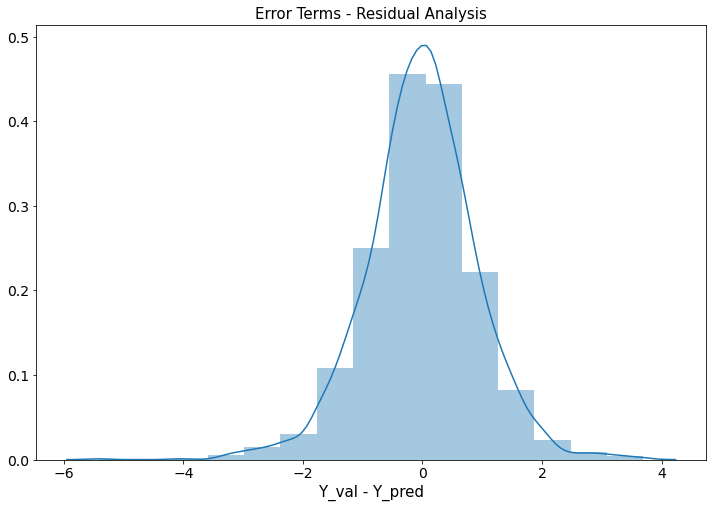

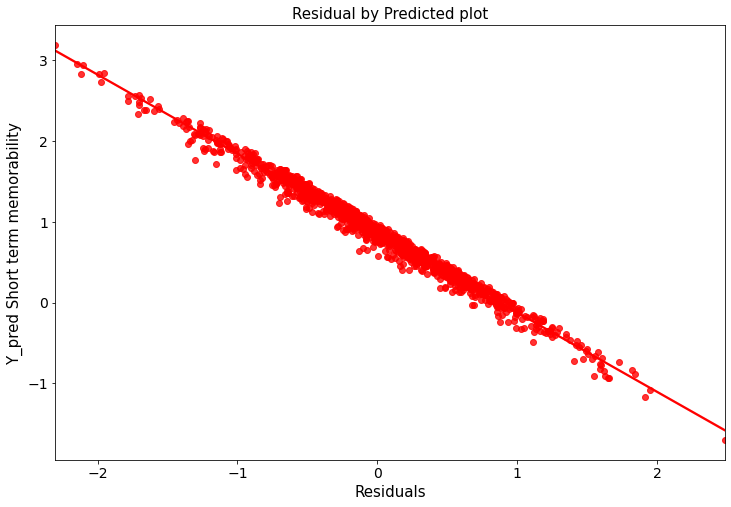

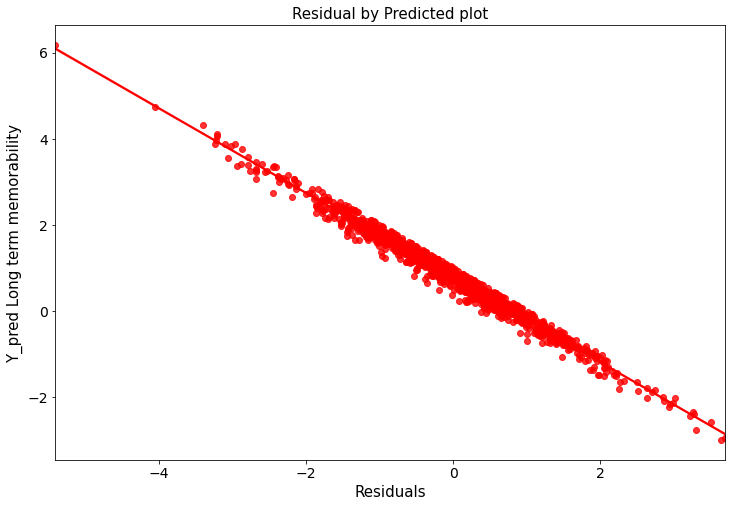

In [58]:
import seaborn as sns


res = Y_val - y_pred

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms - Residual Analysis', fontsize = 15)
plt.xlabel('Y_val - Y_pred', fontsize = 15)
plt.show()

res2 = (Y_val[:,0] - y_pred[:,0])

fig = plt.figure()
sns.regplot(x = res2, y = y_pred[:,0], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Short term memorability',fontsize= 15)
plt.show()

res3 = (Y_val[:,1] - y_pred[:,1])

fig = plt.figure()
sns.regplot(x = res3, y = y_pred[:,1], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Long term memorability',fontsize= 15)
plt.show()

### <span style='color:red'> <span style='background:yellow'> KNN Regression </span> on C3D + HMP features </span>

In [59]:

knnRegressor = KNeighborsRegressor(n_neighbors = 77)
knnRegressor.fit(X_train, Y_train)
y_pred = knnRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)


Short term memorability
Spearman's correlation coefficient is: 0.272

Long term memorability
Spearman's correlation coefficient is: 0.138


### <span style='color:red'> <span style='background:yellow'> Decision Tree Regression </span> on C3D + HMP features </span>

In [60]:

dtRegressor = DecisionTreeRegressor()
dtRegressor.fit(X_train, Y_train)
y_pred = dtRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.038

Long term memorability
Spearman's correlation coefficient is: -0.025


### <span style='color:red'> <span style='background:yellow'> Random Forest Regression </span> on C3D + HMP features </span>

In [61]:

rfRegressor = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=45)
rfRegressor.fit(X_train, Y_train)
y_pred = rfRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.312

Long term memorability
Spearman's correlation coefficient is: 0.131


### <span style='color:red'> <span style='background:yellow'> Neural Network </span> on C3D + HMP features </span>

### <span style='color:blue'> Build the neural network model </span>

In [62]:
# Sequential Model - The Sequential model is a linear stack of layers.

c3d_hmp_Model = Sequential()

# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# Add layers via the .add() method
c3d_hmp_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))

# add dropout - Helps prevent overfitting
c3d_hmp_Model.add(layers.Dropout(0.2))
c3d_hmp_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
c3d_hmp_Model.add(layers.Dropout(0.2))
c3d_hmp_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
c3d_hmp_Model.add(layers.Dropout(0.2))
c3d_hmp_Model.add(layers.Dense(2,activation='sigmoid'))
c3d_hmp_Model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               1235400   
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

### <span style='color:blue'> Compile and Train the Model </span>

In [63]:
c3d_hmp_Model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history_c3d_hmp = c3d_hmp_Model.fit(x=X_train, y=Y_train, batch_size=50, epochs=50, shuffle=True, verbose=False, validation_split=0.2) # validation_data=(X_val, Y_val) 

In [64]:
#Load HMP testing data

print(test_hmp_features.head(2))
print(c3d_test.head(2))


   video                                                HMP
0   7494  [0.022039, 0.005264, 9.8e-05, 0.0, 0.003689, 0...
1   7495  [0.004694, 0.001934, 4e-05, 0.0, 0.001226, 5.8...
   video                                                C3D
0   7494  [0.00013576, 0.0002133, 0.00124759, 1.149e-05,...
1   7495  [0.00012659, 2.377e-05, 0.04950115, 2.418e-05,...


In [65]:
c3d_features_test = c3d_test.filter(['C3D']).to_numpy()
hmp_features_test = test_hmp_features.filter(['HMP']).to_numpy()

In [66]:
counter = 0

cmd_hmp_features_test = np.array([])

combinedListWithC3D_HMP_test = []

for counter in range(2000):
    cmd_hmp_features_test = np.concatenate((c3d_features_test[counter][0], hmp_features_test[counter][0]))
    combinedListWithC3D_HMP_test.append(cmd_hmp_features_test)

print(len(combinedListWithC3D_HMP_test))


2000


In [67]:
c3d_hmp_df_test = pd.DataFrame(data = combinedListWithC3D_HMP_test)

In [68]:
# Load C3D and HMP combined test videos features values in the variable X_test_c3d_hmp

X_test_c3d_hmp = np.stack(c3d_hmp_df_test.values)

print(X_test_c3d_hmp)

[[1.3576000e-04 2.1330000e-04 1.2475900e-03 ... 1.6500000e-04
  4.8800000e-04 1.8700000e-04]
 [1.2659000e-04 2.3770000e-05 4.9501150e-02 ... 1.0900000e-04
  1.3600000e-04 2.9000000e-05]
 [4.8898152e-01 5.8536000e-04 2.4540000e-05 ... 9.2000000e-05
  1.4300000e-04 5.1000000e-05]
 ...
 [5.9629649e-01 3.4448250e-02 9.8050000e-04 ... 2.6200000e-04
  3.5400000e-04 1.1300000e-04]
 [2.5415000e-04 2.1214000e-04 2.3418450e-02 ... 1.2000000e-04
  1.2900000e-04 2.0000000e-05]
 [1.2241518e-01 8.6923975e-01 4.5750000e-05 ... 2.8500000e-04
  4.4900000e-04 2.3200000e-04]]


### <span style='color:green'> Visualisation Plots </span>

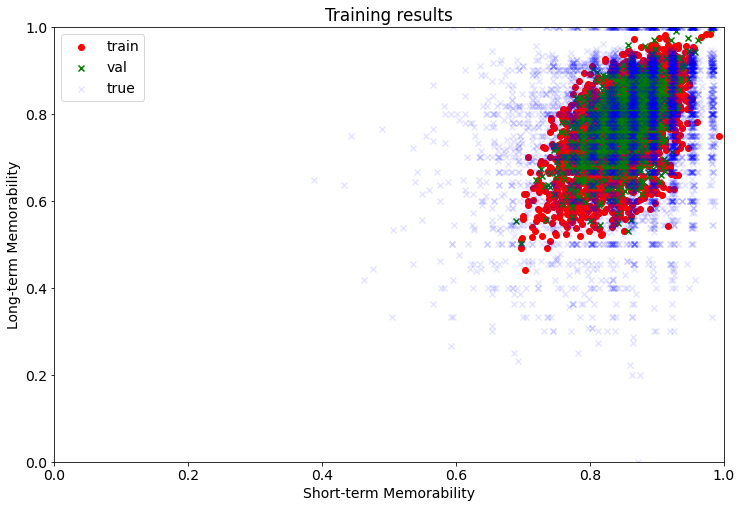

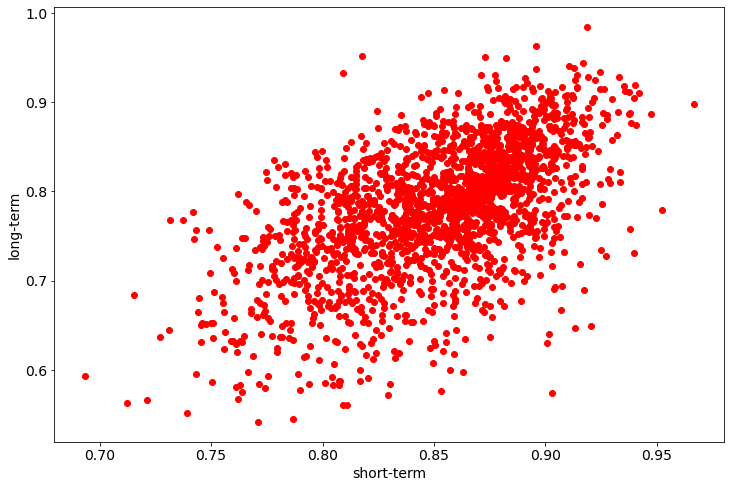

In [69]:
Y_predicted_train = c3d_hmp_Model.predict(X_train)
Y_predicted_validation = c3d_hmp_Model.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='r',label='train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='g',label='val')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Short-term Memorability')
plt.ylabel('Long-term Memorability')
plt.title('Training results')
plt.show()

# plot testing results
Y_pred = c3d_hmp_Model.predict(X_test_c3d_hmp[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()


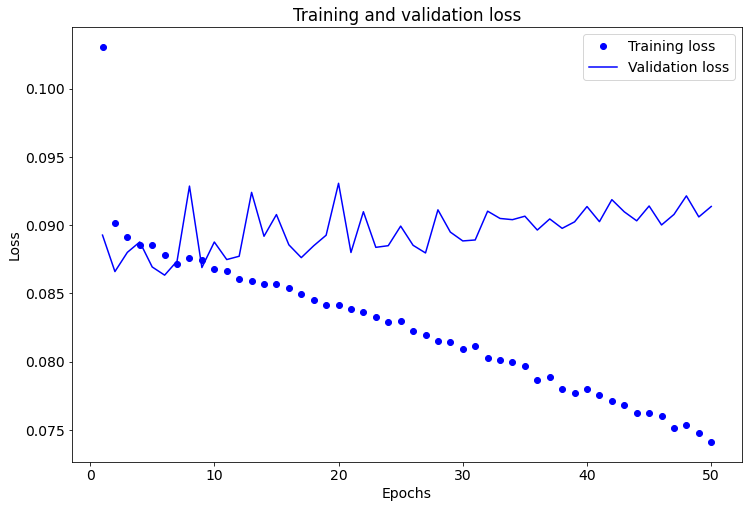

In [70]:
# Visualising the training loss vs validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <span style='color:red'> Spearmann score for Short term and Long term memorability </span>

In [71]:
# Predict the Short term and Long term memorability score using model for C3D test data set

Y_prediction = c3d_hmp_Model.predict(X_val)

In [72]:
# Predict Short term and Long term Spearmann's correlation coefficient scores
Predict_Spearman_Score(Y_prediction,Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.272

Long term memorability
Spearman's correlation coefficient is: 0.085


In [73]:
# Predict loss and accuracy of Sequential mode
score = c3d_hmp_Model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.0935773253440857
Validation accuracy: 0.659166693687439


# <span style='color:blue'> Memorability Prediction with Aesthetic features </span>

### <span style='color:orange'> Function to read Aesthetic features </span>

In [74]:
# Function to read each line of Aesthetics Mean file for its features"""              
def read_aesthetic_features(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            AES =[float(item) for item in line.split(',')] # convert to float type, using default separator
    return AES


In [75]:
import os

aesthetic_features = []


# Load the C3D feature values in a Panda's dataframe
AESTHETIC_FILENAMES = current_directory + '/Dev-set/aesthetic_visual_features/'
# Load video related features first as it helps with the organization of the video names
videos = ground_truth_labels.video.values

pbar = ProgressBar()

aesthetic_features = pd.DataFrame({'video': videos,
                   'aesthetics': [read_aesthetic_features(AESTHETIC_FILENAMES +'aesthetic_feat_dev-set_mean'+'/'+ os.path.splitext(videos[video])[0]+'.txt') for video in pbar(range(len(videos)))],
                       })

aesthetic_df = pd.DataFrame(aesthetic_features)
aesthetic_df.head(2)

100% |########################################################################|


,video,aesthetics
0,video3.webm,"[0.18389, 0.713733, 0.202302, 0.610132, 0.1242..."
1,video4.webm,"[0.147255, 0.550718, 0.460299, 0.424981, 0.341..."


In [76]:
aesthetic_df.shape

(6000, 2)

In [77]:
aesthetic_df.isnull().values.any()

False

#### <span style='color:green'> Aesthetic features are broken into train and validation set </span>

In [78]:
X_ath = np.stack(aesthetic_df['aesthetics'].values)
Y_ath = ground_truth_labels[['short-term_memorability','long-term_memorability']].values

In [79]:
X_train,X_val,Y_train,Y_val = train_test_split(X_ath, Y_ath, test_size=0.2, random_state=2)

### <span style='color:red'> <span style='background:yellow'>Linear Regression</span> on Aesthetic features </span>

In [80]:
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, Y_train)
y_pred = linearRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.231

Long term memorability
Spearman's correlation coefficient is: 0.069


#### <span style='color:green'> Residuals by Predicted plots </span>

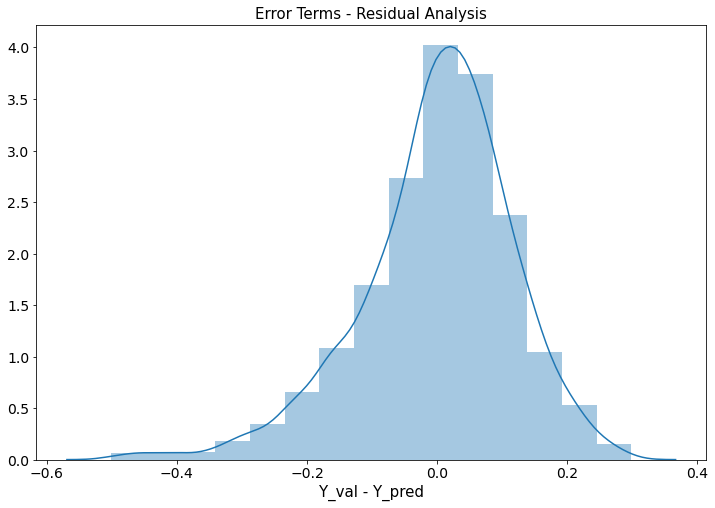

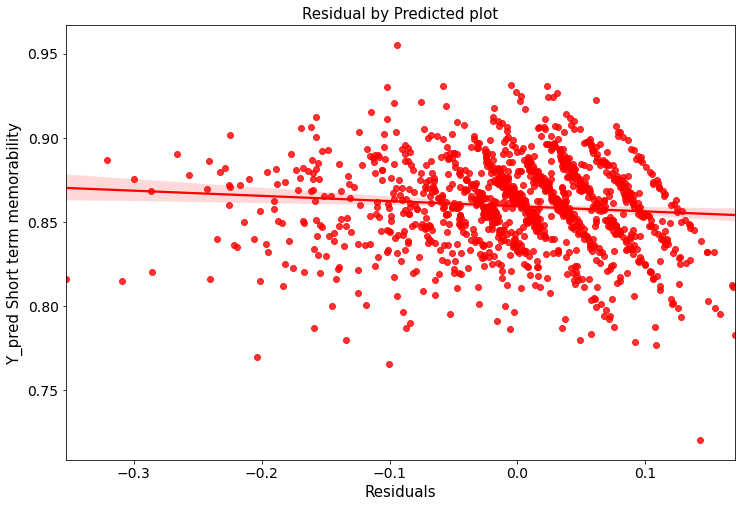

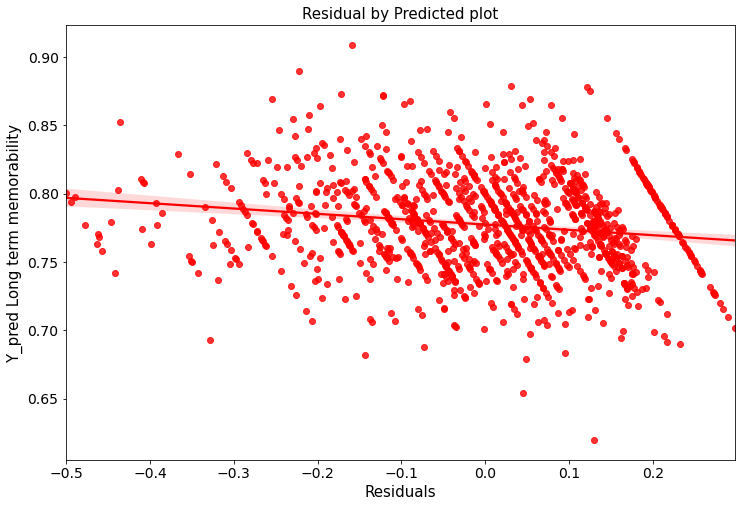

In [81]:
import seaborn as sns


res = Y_val - y_pred

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms - Residual Analysis', fontsize = 15)
plt.xlabel('Y_val - Y_pred', fontsize = 15)
plt.show()

res2 = (Y_val[:,0] - y_pred[:,0])

fig = plt.figure()
sns.regplot(x = res2, y = y_pred[:,0], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Short term memorability',fontsize= 15)
plt.show()

res3 = (Y_val[:,1] - y_pred[:,1])

fig = plt.figure()
sns.regplot(x = res3, y = y_pred[:,1], data = None, scatter = True, color = 'red')
plt.title('Residual by Predicted plot', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('Y_pred Long term memorability',fontsize= 15)
plt.show()

### <span style='color:red'> <span style='background:yellow'>KNN Regression </span> on Aesthetic features </span>

In [82]:

knnRegressor = KNeighborsRegressor(n_neighbors = 77)
knnRegressor.fit(X_train, Y_train)
y_pred = knnRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.124

Long term memorability
Spearman's correlation coefficient is: 0.079


### <span style='color:red'> <span style='background:yellow'>Decision Tree Regresion </span> on Aesthetic features </span>

In [83]:
#Decision Tree Regression

dtRegressor = DecisionTreeRegressor()
dtRegressor.fit(X_train, Y_train)
y_pred = dtRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.076

Long term memorability
Spearman's correlation coefficient is: 0.027


### <span style='color:red'> <span style='background:yellow'>Random Forest</span> on Aesthetic features </span>

In [84]:

rfRegressor = RandomForestRegressor(n_estimators=100, max_depth=16, min_samples_split = 5, random_state=5)
rfRegressor.fit(X_train, Y_train)
y_pred = rfRegressor.predict(X_val)
Predict_Spearman_Score(y_pred, Y_val)

Short term memorability
Spearman's correlation coefficient is: 0.259

Long term memorability
Spearman's correlation coefficient is: 0.101


### <span style='color:red'> <span style='background:yellow'>Neural Network</span> on Aesthetic features </span>

### <span style='color:blue'> Build the neural network model </span>

In [85]:
# Sequential Model - The Sequential model is a linear stack of layers.

aesthetic_Model = Sequential()

# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# Add layers via the .add() method
aesthetic_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(X_ath.shape[1],)))

# add dropout - Helps prevent overfitting
aesthetic_Model.add(layers.Dropout(0.2))
aesthetic_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
aesthetic_Model.add(layers.Dropout(0.2))
aesthetic_Model.add(layers.Dense(200,activation='relu',kernel_regularizer=None))
aesthetic_Model.add(layers.Dropout(0.2))
aesthetic_Model.add(layers.Dense(2,activation='sigmoid'))
aesthetic_Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               22000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                

### <span style='color:blue'> Compile and train the model </span>

In [86]:
aesthetic_Model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history = aesthetic_Model.fit(x=X_train, y=Y_train, batch_size=50, epochs=50, shuffle=True, verbose=False, validation_split=0.2) # validation_data=(X_val, Y_val) 

#### <span style='color:green'> Read the test Aesthetic mean features from Test-Dev folder </span>

Store the test features value in X_aesthetic test variable

In [87]:

AESTHETIC_FILENAMES_TEST = current_directory + '/Test-set/aesthetic_vis_features_test/'
# Load video related features first as it helps with the organization of the video names
videos = ground_truth_test_labels.video.values

aesthethic_test_features = []
pbar = ProgressBar()

aesthethic_test_features = pd.DataFrame({'video': videos,
                   'aesthetics': [read_aesthetic_features(AESTHETIC_FILENAMES_TEST +'mean'+'/'+ 'video' + str(video) +'.txt') for video in pbar (videos)],
                       })


aesthetic_test_df = pd.DataFrame(aesthethic_test_features) 
aesthetic_test_df.head(2)


100% |########################################################################|


,video,aesthetics
0,7494,"[0.15188, 0.435622, 0.385821, 0.324642, 0.3163..."
1,7495,"[0.346129, 0.39686, 0.518731, 0.417674, 0.4222..."


In [88]:
aesthetic_test_features = np.stack(aesthetic_test_df['aesthetics'].values)
print(aesthetic_test_features)

[[ 0.15188   0.435622  0.385821 ... -0.076401 -0.436021  1.157126]
 [ 0.346129  0.39686   0.518731 ...  0.628249  0.654099  1.942465]
 [ 0.126344  0.225354  0.479295 ... -0.101714  0.68877   0.936501]
 ...
 [ 0.299844  0.207785  0.502194 ...  0.118141  2.428633  0.592998]
 [ 0.293313  0.207653  0.687289 ...  0.236496 -0.744131 -1.012016]
 [ 0.302608  0.245883  0.702457 ...  0.672065  0.346146  0.150276]]


In [89]:
X_aesthetic_test = aesthetic_test_features

### <span style='color:green'> Visualisation Plots </span>

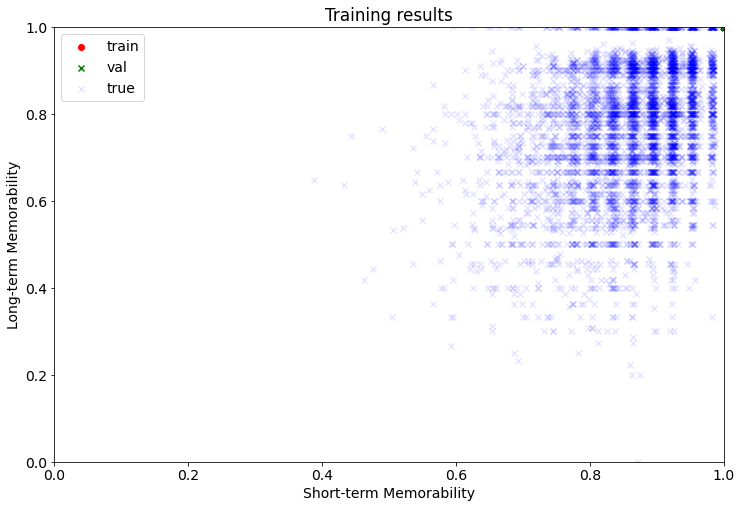

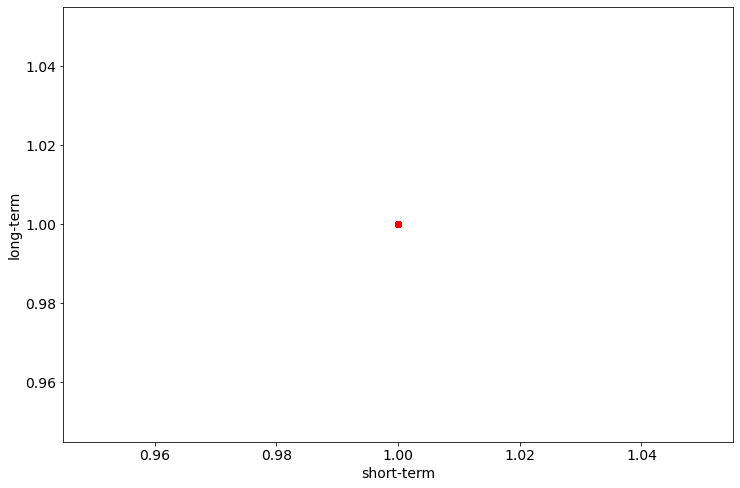

In [90]:
Y_predicted_train = aesthetic_Model.predict(X_train)
Y_predicted_validation = aesthetic_Model.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='r',label='train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='g',label='val')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Short-term Memorability')
plt.ylabel('Long-term Memorability')
plt.title('Training results')
plt.show()

# plot testing results
Y_pred = aesthetic_Model.predict(X_aesthetic_test[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()

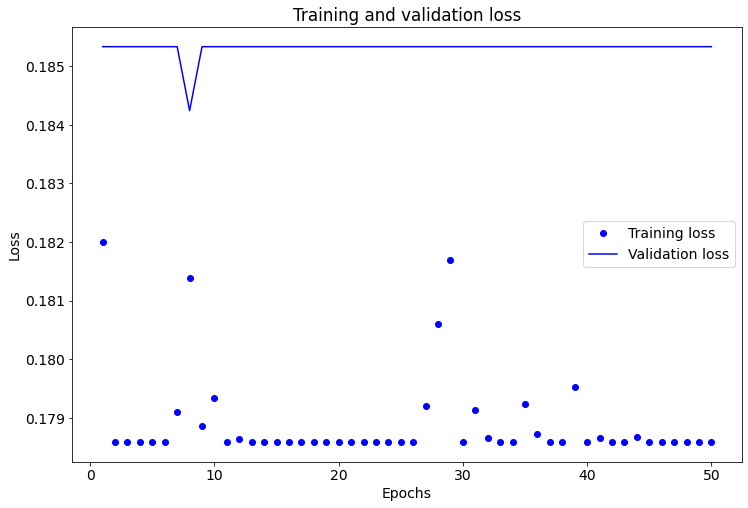

In [91]:
# Visualising the training loss vs validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <span style='color:red'> Short term and Long term Spearmann's correlation coefficient scores </span>

In [92]:
# Predict Short term and Long term Spearmann's correlation coefficient scores

Y_prediction = aesthetic_Model.predict(X_val)

Predict_Spearman_Score(Y_prediction,Y_val)

Short term memorability
Spearman's correlation coefficient is: nan

Long term memorability
Spearman's correlation coefficient is: nan


In [93]:
# Predict loss and accuracy of Sequential mode
score = aesthetic_Model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.1822887361049652
Validation accuracy: 0.7016666531562805


### <span style='color:blue'> Regression Model Comparison Table </span>

<html>
<head>

</head>
    
<body>
    <p> <b> Best Score is for <span style='color:red'> Neural Network with HMP Feature </span> as per below table comparison for various machine learning algorithms
    </b> </p>
<table style="width:90%" align="left">
<tr>
<th>     </th>
<th>  </th>
<th style="text-align:left"> HMP  </th>
<th>  </th>
<th style="text-align:left"> C3D </th>
<th> </th>
<th style="text-align:left"> HMP+C3D </th>
<th> </th>
<th style="text-align:left"> AESTHETICS </th>
</tr>

<tr>
<td>      </td>
<td> SHORT TERM </td>
<td> LONG TERM </td>
<td> SHORT TERM </td>
<td> LONG TERM  </td>
<td> SHORT TERM </td>
<td> LONG TERM  </td>
<td> SHORT TERM </td>
<td> LONG TERM  </td>
</tr>

<tr>
<td> Linear Regression </td>
<td> 0.036 </td>
<td> -0.004 </td>
<td> 0.277 </td>
<td> 0.103  </td>
<td> 0.212 </td>
<td> 0.003  </td>
<td> 0.231 </td>
<td> 0.069  </td>
</tr>
    
 <tr>
<td> KNN </td>
<td> 0.237 </td>
<td> 0.075 </td>
<td> 0.251 </td>
<td> 0.097  </td>
<td> 0.272 </td>
<td> 0.138  </td>
<td> 0.124 </td>
<td> 0.079  </td>
</tr>
    
 <tr>
<td> Decision Tree </td>
<td> 0.077 </td>
<td> 0.033 </td>
<td> 0.062 </td>
<td> -0.007  </td>
<td> 0.038 </td>
<td> -0.025  </td>
<td> 0.083 </td>
<td> 0.028  </td>
</tr>
    
  <tr>
<td> Random Forest </td>
<td> 0.275 </td>
<td> 0.113 </td>
      <td> 0.302 </td>
<td> 0.109  </td>
<td> 0.312 </td>
<td> 0.131  </td>
<td> 0.259 </td>
<td> 0.101  </td>
</tr>
    
   <tr>
<td> Neural Network </td>
<td>  <span style="color:red"> <span style="background:yellow"> <b>0.332 </b> </span></span> </td>
<td> 0.119 </td>
<td> 0.236 </td>
<td> 0.095 </td>
<td> 0.280 </td>
<td> 0.104 </td>
<td> nan   </td>
<td> nan   </td>
</tr>
</table>
    
</body>
</html>

# <span style='color:red'> Saving the result for best model score </span>

In [94]:
# load the ground truth values

testdata = ground_truth_test_labels.copy()

testdata.head(5)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [95]:
# Predict the Short term and Long term memorability from the model

Y_pred = hmp_model.predict(X_test_hmp[:,:],batch_size=32)
print(Y_pred)

[[0.87429637 0.78126574]
 [0.8738085  0.7894747 ]
 [0.9002304  0.8073149 ]
 ...
 [0.90877724 0.82095355]
 [0.8694085  0.8150958 ]
 [0.9116589  0.8292954 ]]


In [96]:
# Load predicted score for Short term and Long term memorability in the testdata dataframe
testdata['short-term_memorability'] = Y_pred[ : , 0]
testdata['long-term_memorability'] = Y_pred[ : , 1]
testdata.head(5)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.874296,33,0.781266,12
1,7495,0.873809,34,0.789475,10
2,7496,0.900230,32,0.807315,13
3,7497,0.912412,33,0.834845,10
4,7498,0.789758,33,0.666627,10


In [97]:
# Update the result for Short Term Memorability and Long Term Memorability for better performing HMP compared to C3D
testdata.to_csv('Arun_Baluni_20214584_predictions.csv', encoding='utf-8', index=False)